In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Simulate GBM

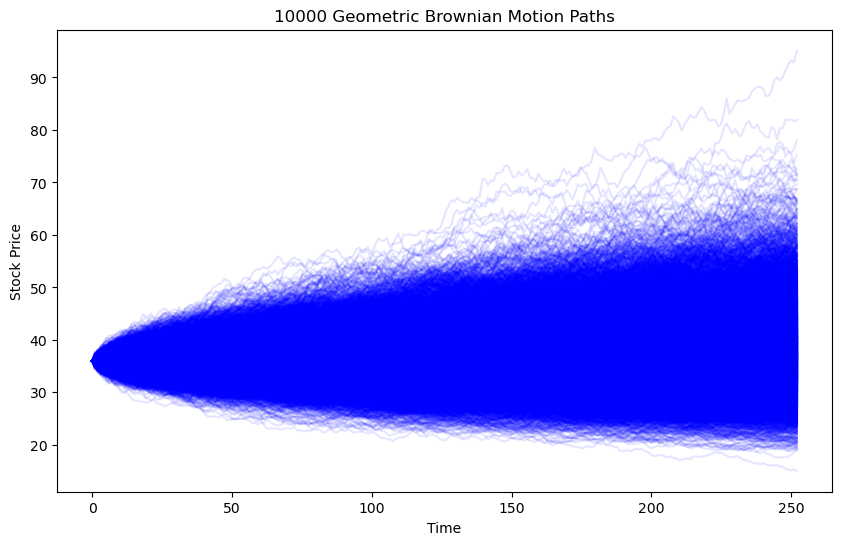

In [2]:
# Parameters as specified

S0 = 36  # Initial stock price

T = 252  # Total time
dt = 1  # Time increment
mu = 0.06 / T  # Adjusted daily drift coefficient
sigma = 0.2 / np.sqrt(T)  # Adjusted daily volatility coefficient
N = round(T / dt)  # Number of time steps
n = 10000  # Number of simulations

# Preparing the Wiener process increment
dW = np.sqrt(dt) * np.random.randn(n, N)

# Initializing the stock price array
S = np.zeros((n, N))
S[:, 0] = S0

# Simulating the Geometric Brownian Motion using the SDE dS = mu*S*dt + sigma*S*dW
for i in range(1, N):
    S[:, i] = S[:, i - 1] + mu * S[:, i - 1] * dt + sigma * S[:, i - 1] * dW[:, i - 1]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, N), S.T, alpha=0.1, color='blue')
plt.title('10000 Geometric Brownian Motion Paths')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Pricer

In [3]:
def LSMC_pricer(S, K, mu, n, N, type, order=2):

    def payoff(S, K, type):
        if type == 'call':
            return np.maximum(S - K, 0)
        else:  # Assuming 'put'
            return np.maximum(K - S, 0)

    def discount(mu, N, t):
        return np.tile(np.exp(mu * (t - 1)) * np.exp(-mu * np.arange(N)).reshape(1, -1), (n, 1))

    def initialize_cashflows(S, K, type):
        C = np.zeros((n, N))
        C[:, -1] = payoff(S[:, -1], K, type)
        return C

    def remove_outdated_cashflows(C):
        cumulative_non_zeros = np.cumsum(C != 0, axis=1)
        C[cumulative_non_zeros > 1] = 0
        return C

    def filter_OTM(S, C, D, t, type):
        flter = S[:, t] < K if type == 'put' else S[:, t] > K
        return S[:, t][flter], np.sum(C * D, axis=1)[flter], flter

    C = initialize_cashflows(S, K, type)
    for t in range(N - 2, 0, -1):
        D = discount(mu, N, t)
        # removing OTM paths from regression
        X, Y, flter = filter_OTM(S, C, D, t, type)
        # polynomial regression
        regression = np.polyfit(X, Y, order)
        continuation = np.polyval(regression, X)
        # adding OTM paths back to the cashflows
        Y_nofilter = np.zeros((n, 1))
        Y_nofilter[flter] = np.where(payoff(X, K, type) > continuation, payoff(X, K, type), 0).reshape(-1, 1)
        C[:, t] = np.squeeze(Y_nofilter)
        # removing cashflows already exercised
        C = remove_outdated_cashflows(C)

    price = D * C
    price = np.mean(np.sum(price, axis=1))
    exercise_matrix = np.where(C > 0, 1, 0)
    return price, exercise_matrix

In [10]:
# Plotting the paths along with exercise points
def plotter(S, exercise_matrix, K, N, n, alpha=0.05, size=6, offset=0, skip=20):
    plt.figure(figsize=(10, 6))
    for i in range(n):
        plt.plot(S[i, :], color='blue', alpha=alpha, zorder=1)  # Plot stock paths

    x, y = np.where(exercise_matrix == 1)
    plt.scatter(y, S[x, y], color='red', zorder=2, s=size)

    plt.hlines(K, 0, N, color="black", zorder=10000000, linestyles='dashed')

    plt.title('Option Exercise Points along Stock Paths')
    plt.xlim(0, N+offset)
    plt.xticks(range(0, N, skip))
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.show()

# Paper values complex

In [18]:
# price a european call option using the Monte Carlo method
K = 40  # Strike price
mu = 0.06
C0 = np.exp(-mu) * np.mean(np.maximum(K - S[:, -1], 0))  # put option price
print('The European put option price is', round(C0, 3))

S = S
K = 40
mu = 0.06 / 252
n = 10000
N = 252
order=4
type = 'put'
american_option_price, exercise_matrix = LSMC_pricer(S, K, mu, n, N, type,order=4)
print('The American put option price is', round(american_option_price, 3))

The European put option price is 3.831
The American put option price is 4.492


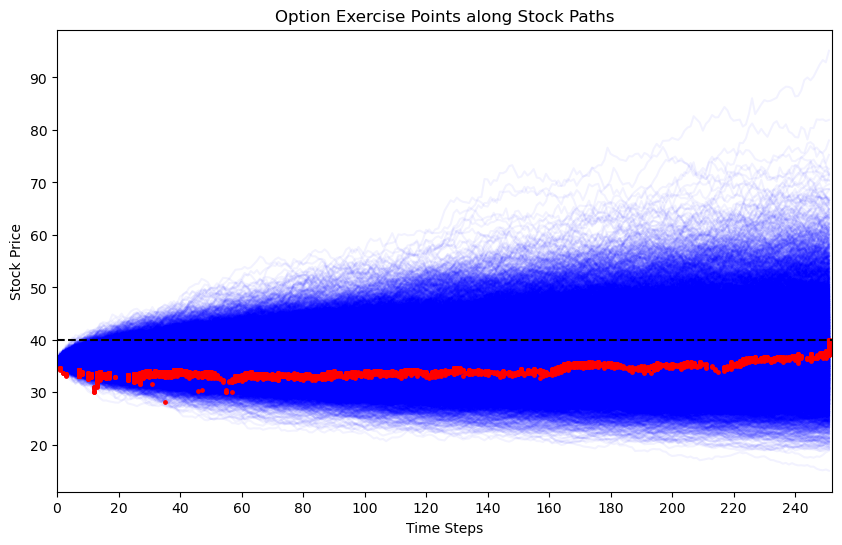

In [19]:
plotter(S, exercise_matrix, K, N, n)

# Paper values simple

In [7]:
# trying the paper example

S2 = np.array([
    [1.00, 1.09, 1.08, 1.34],
    [1.00, 1.16, 1.26, 1.54],
    [1.00, 1.22, 1.07, 1.03],
    [1.00, 0.93, 0.97, 0.92],
    [1.00, 1.11, 1.56, 1.52],
    [1.00, 0.76, 0.77, 0.90],
    [1.00, 0.92, 0.84, 1.01],
    [1.00, 0.88, 1.22, 1.34]
])

n2 = 8
N2 = 4
mu2 = 0.06
K2 = 1.10

american_option_price2, exercise_matrix2 = LSMC_pricer(S2, K2, mu2, n2, N2, 'put')
print('The American call option price is', american_option_price2)

The American call option price is 0.11443433004505696


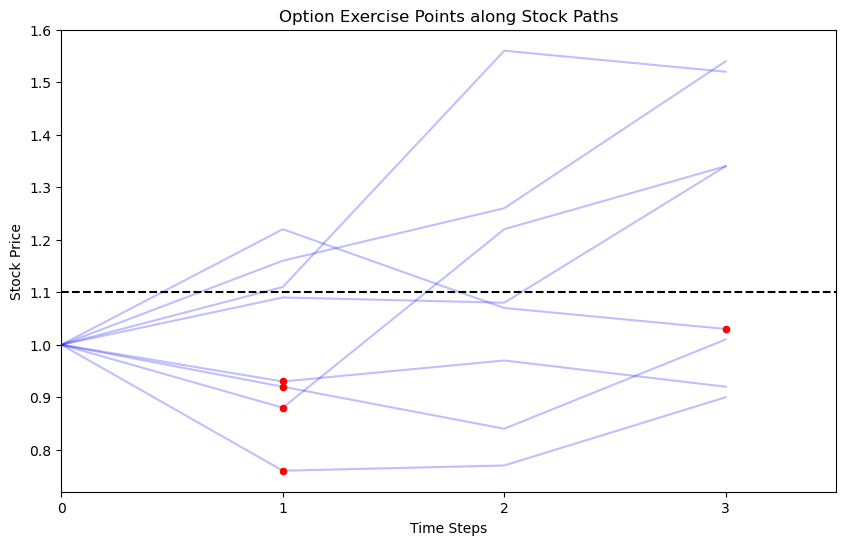

In [14]:
plotter(S2, exercise_matrix2, K2, N2, n2, alpha=0.25, size=20, offset=-0.5, skip=1)